In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.io.wavfile as sp
import IPython.display as ipd
import math

/Users/saksham/anaconda3/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.2
  UserWarning)


In [5]:
def  block_audio(x,blockSize,hopSize,fs):
    # allocate memory
    numBlocks = math.ceil(x.size / hopSize)
    xb = np.zeros([numBlocks, blockSize])
    # compute time stamps
    t = (np.arange(0, numBlocks) * hopSize) / fs
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)
    for n in range(0, numBlocks):
        i_start = n * hopSize
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]
    return (xb,t)


def compute_hann(iWindowLength):
    return 0.5 - (0.5 * np.cos(2 * np.pi / iWindowLength * np.arange(iWindowLength)))

def compute_spectrogram(xb, fs):
    numBlocks = xb.shape[0]
    blockSize = xb.shape[1]
    # calculate mid points of freq bins
    num_freqbins = blockSize/2+1
    fInHz = (np.arange(num_freqbins) + 0.5)*fs/blockSize

    afWindow = compute_hann(xb.shape[1])
    X = np.zeros([math.ceil(xb.shape[1]/2+1), numBlocks])
    
    for n in range(0, numBlocks):
        # apply window
        tmp = abs(np.fft.fft(xb[n,:] * afWindow))*2/xb.shape[1]
    
        # compute magnitude spectrum
        X[:,n] = tmp[range(math.ceil(tmp.size/2+1))] 

        
        X[[0,math.ceil(tmp.size/2)],n]= X[[0,math.ceil(tmp.size/2)],n]/np.sqrt(2)
#let's be pedantic about normalization
    
    return X, fInHz


def plot_spectrogram(spectrogram, fs, hopSize):
    
    t = hopSize*np.arange(spectrogram.shape[0])/fs
    f = np.arange(0,fs/2, fs/2/spectrogram.shape[1])

    plt.figure(figsize = (15, 7))
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.pcolormesh(t, f, spectrogram.T)
    plt.show()

def convert_freq2midi(fInHz, fA4InHz = 440):
    def convert_freq2midi_scalar(f, fA4InHz):
 
        if f <= 0:
            return 0
        else:
            return (69 + 12 * np.log2(f/fA4InHz))
    fInHz = np.asarray(fInHz)
    if fInHz.ndim == 0:
       return convert_freq2midi_scalar(fInHz,fA4InHz)
    midi = np.zeros(fInHz.shape)
    for k,f in enumerate(fInHz):
        midi[k] =  convert_freq2midi_scalar(f,fA4InHz)
            
    return (midi)

## A. Tuning Frequency Estimation: [25points]

In [40]:
# 1. [5 points] Write a function [spectralPeaks] = get_spectral_peaks(X) that returns the top 20 spectral peak bins of each column of magnitude 
# spectrogram X.

path = os.getcwd() + '/dataset/key_tf/tuning_eval/audio/'
wav = os.listdir(path)
print (wav)
file = wav[3]
print (path + file)
fs, x = sp.read(path + file)
x = x.astype(np.float64)
x = x/max(x)

['poke_center.wav', 'vader.wav', 'cycling_road.wav', 'pirates.wav', 'pallet_town.wav']
/Users/saksham/Desktop/Music Tech/Gatech/Sem 1/Computational Music Analysis/Assignment/Assignment 4/aca-assignment-4/dataset/key_tf/tuning_eval/audio/pirates.wav


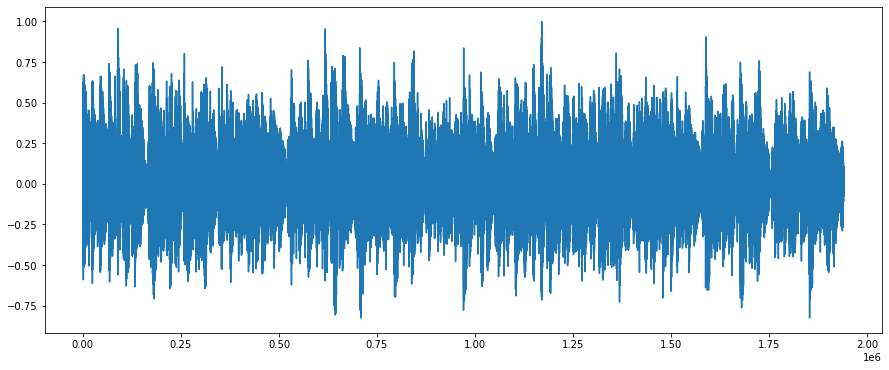

In [41]:
plt.figure(figsize = (15, 6))
plt.plot(x)

In [42]:
file

'pirates.wav'

/Users/saksham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


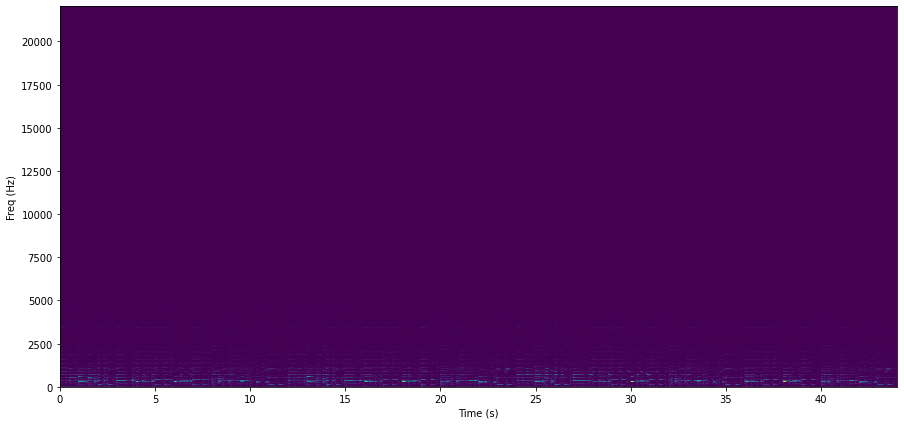

In [43]:
blockSize = 4096
hopSize = 2048

xb, tInSec = block_audio(x, blockSize, hopSize, fs)
X, fInHz = compute_spectrogram(xb, fs)
plot_spectrogram(X.T, fs, hopSize)

In [44]:
# Identify peaks

def get_spectral_peaks(X):

    spectralPeaks = np.zeros([X.shape[1], 20])
    for i, block in enumerate(X.T):
        peaks = scipy.signal.find_peaks(block)[0]
        mag_peaks = block[peaks]
        max_peaks = np.argsort(mag_peaks)[-20:]
        spectralPeaks[i] = peaks[max_peaks]
    
    return spectralPeaks


In [45]:
abc = get_spectral_peaks(X)
abc[0]

array([132., 209., 146.,  57., 166., 124., 188.,  74.,  99., 104.,  15.,
        82.,  66.,   8.,  49.,  33.,  24.,  21.,  62.,  41.])

In [101]:
# 2. [20 points] Write a function [tfInHz] = estimate_tuning_freq(x, blockSize, hopSize, fs) to return the tuning frequency. 
# x is the time domain audio signal, blockSize is the block size, hopSize is the hopSize, and fs is the sample rate. 
# Use the deviation from the equally tempered scale in Cent for your estimate. You will use get_spectral_peaks() function to obtain the 
# top 20 spectral peaks for each block. Use functions from the reference solutions for previous assignments for blocking and computing the 
# spectrogram. For each block, compute the deviation of the peak bins from the nearest equally tempered pitch in cents. 
# Then, compute a histogram of the deviations in Cent and derive the tuning frequency from the location of the max of this histogram. 
# Make sure your function works for any blockSizes.

In [77]:
def estimate_tuning_freq(x, blockSize, hopSize, fs):
    
    xb, tInSec = block_audio(x, blockSize, hopSize, fs)
    X, fInHz = compute_spectrogram(xb, fs)
    freq = get_spectral_peaks(X)
    numBlocks = X.shape[1]
    tf_audio = np.zeros(numBlocks*len(freq))
    for i, freq_block in enumerate(freq):
        # Find nearest temparament
        freq_MIDI = convert_freq2midi(freq_block)
        freq_MIDI_ref = np.round(freq_MIDI)
        # compute deltaC for a block
        deltaC_block = 100*(freq_MIDI - freq_MIDI_ref)
        # Store all delta c's.
        tf_audio[20*i:20*(i+1)] = deltaC_block
    hist, bins = np.histogram(tf_audio, bins = 10)
    center = (bins[:-1] + bins[1:]) / 2
    tf = center[np.argmax(hist)]
    tfInHz = 440*2**(tf/1200)

    return tfInHz

In [47]:
# Plot histogram

def plot_histogram(hist, bins):
    center = (bins[:-1] + bins[1:]) / 2
    width = 0.5 * (bins[1] - bins[0])
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [48]:
tfInHz = estimate_tuning_freq(x, blockSize, hopSize, fs)

[   483   2452    799    766   1809 884163   4635    965   2005    627]


## Key detection

In [49]:
def extract_pitch_chroma(X, fs, tfInHz):

# C3 = 130.81Hz
# B5 = 493.81Hz
    
    # Relationship between C3 and A4
    f = tfInHz*(2**(-21/12))

    pitch_classes = 12
    numOctaves = 3

    # initialise filterbank
    fb = np.zeros([pitch_classes, X.shape[0]])

    # Create filters for individual pitch classes
    for i in np.arange(pitch_classes):
        fb_tmp = np.zeros([X.shape[0]])
        for j in np.arange(numOctaves):
            # calculate the bounds for each and replace them with "1" in the actual filter
            f_tmp = f*2**j
            current_bin = f_tmp*2*(X.shape[0]-1)/fs
            bounds = np.array([2**(-1/(2*pitch_classes)), 2**(1/(2*pitch_classes))])*current_bin
            low = int(np.ceil(bounds[0]))
            high = int(np.ceil(bounds[1]))
            range = np.arange(low, high)
            nf = len(range)
            if len(range) == 0:
                range = low
                nf = 1
            # Normalize to the length of 1
            fb_tmp[range] = 1/nf
            j += 1
        fb[i] = fb_tmp
        f = f*2**(1/pitch_classes)
        i += 1

    pc = np.dot(fb, X**2)
    normalize = pc.sum(axis = 0)
    # Avoid division by 0
    normalize[normalize==0] = 1
    pc = pc/normalize

    return pc

In [50]:
pc = extract_pitch_chroma(X, fs, tfInHz)

In [51]:
pc.shape

(12, 948)

/Users/saksham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


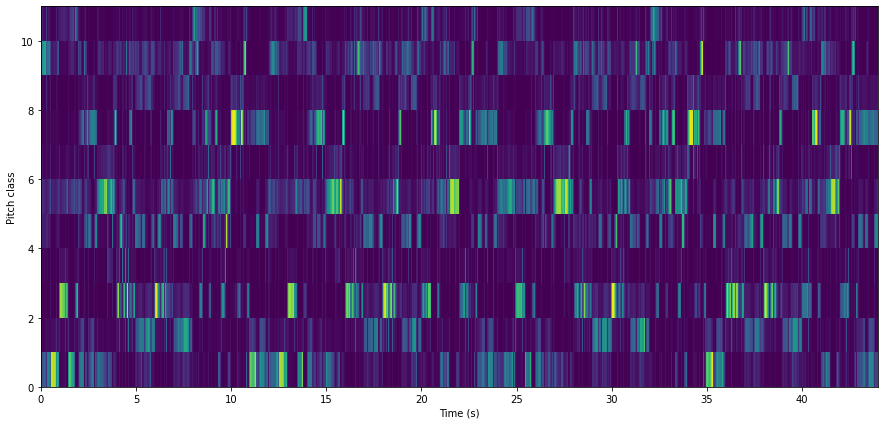

In [52]:
t = hopSize*np.arange(pc.shape[1])/fs
classes = np.arange(pc.shape[0])

plt.figure(figsize = (15, 7))
plt.xlabel('Time (s)')
plt.ylabel('Pitch class')
plt.pcolormesh(t, classes, pc)
plt.show()

In [64]:
p0 = np.zeros(pc.shape[1])
for i, block in enumerate(pc.T):
    p0[i] = np.argmax(block)
p0

array([ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  0.,  0.,  9.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       10.,  2.,  2.,  9.,  0.,  0.,  0.,  0.,  0.,  7.,  9.,  4.,  4.,
        7.,  4.,  4.,  4.,  7.,  7.,  7.,  7.,  7.,  4.,  4.,  4.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  7.,  7.,  2.,  2.,  2.,  3.,  4.,
        4.,  3.,  2.,  2.,  3.,  9.,  2.,  2.,  1.,  7.,  7.,  7.,  9.,
        2.,  2.,  2.,  4.,  4.,  4.,  4.,  1.,  1.,  1.,  4.,  1.,  1.,
        4.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  2.,
        2.,  2.,  2.,  2.,  4.,  4.,  2.,  2.,  2.,  5.,  5.,  2.,  1.,
        7.,  5.,  5.,  6.,  7.,  7.,  5.,  4.,  4.,  4.,  4.,  1.,  1.,
        1.,  9.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  9.,
        9.,  4.,  9., 10., 10., 10., 10., 10.,  9., 10., 10.,  2

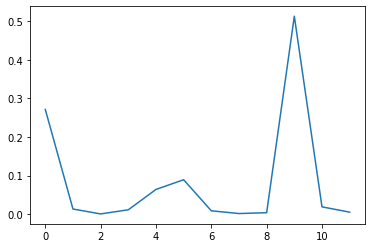

In [65]:
plt.plot(pc[:, 4])

In [60]:
pc.shape

(12, 948)

In [75]:
from scipy.io.wavfile import read as wavread

def ToolReadAudio(cAudioFilePath):    
    [samplerate, x] = wavread(cAudioFilePath)    
    if x.dtype == 'float32':        
        audio = x    
    else:        
        # change range to [-1,1)        
        if x.dtype == 'uint8':            
            nbits = 8        
        elif x.dtype == 'int16':            
            nbits = 16        
        elif x.dtype == 'int32':            
            nbits = 32        
        audio = x / float(2**(nbits - 1))    
        # special case of unsigned format    
    if x.dtype == 'uint8':        
        audio = audio - 1.    
    return (samplerate, audio)

def eval_tfe(pathToAudio, pathToGT):
    for name in os.listdir(pathToAudio):
        if name.endswith(".wav"):
            name=name[:-4]
            sr,x = ToolReadAudio(pathToAudio+name+'.wav')
            lut = np.loadtxt(pathToGT+name+'.txt')
            tfHz = estimate_tuning_freq(x,blockSize,hopSize,sr)
            print(name)
            print(tfHz)
            print(lut)
            print('Difference: ',lut - tfHz)
            print("-------------------------------------------")

In [78]:
pathToAudio = os.getcwd() + '/dataset/key_tf/tuning_eval/audio/'
pathToGT = os.getcwd() + '/dataset/key_tf/tuning_eval/GT/'
eval_tfe(pathToAudio, pathToGT)

440.0
poke_center
441.1609304588115
440.0
Difference:  -1.1609304588114924
-------------------------------------------
437.72
vader
441.17605471895774
437.72
Difference:  -3.4560547189577164
-------------------------------------------
442.55
cycling_road
441.17605471895774
442.55
Difference:  1.3739452810422677
-------------------------------------------
444.34
pirates
441.17605471895774
444.34
Difference:  3.1639452810422313
-------------------------------------------
434.44
pallet_town
441.17605471895774
434.44
Difference:  -6.736054718957746
-------------------------------------------


In [81]:
def detect_key(x, blockSize, hopSize, fs, bTune = True):
    
    # Krumhansl
    t_pc = np.array([[6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88],
                     [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]])
    
    t_pc = t_pc / t_pc.sum(axis=1, keepdims=True)
    
    # key names
    KeyLable = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2,
                         15, 16, 17, 18, 19, 20, 21, 22, 23, 12, 13, 14])
    
    xb, timeInSec = block_audio(x, blockSize, hopSize, fs)
    num_block, blockSize = xb.shape
    
    X, fInHz = compute_spectrogram(xb, fs)
    if bTune:
        tfInHz = estimate_tuning_freq(x, blockSize, hopSize, fs)
        pitchChroma = extract_pitch_chroma(X, fs, tfInHz)
    else:
        pitchChroma = extract_pitch_chroma(X, fs, 440)
    pitchChroma = pitchChroma.mean(axis=1)
    pitchChroma = np.concatenate((pitchChroma, pitchChroma), axis=0).reshape(2, 12)
    
    distance = np.zeros(t_pc.shape)
    
    for i in range(12):
        distance[:,i] = np.sum(np.abs(pitchChroma - np.roll(t_pc, i, axis=1)), axis=1)
        
    
    # minimum distance
    keyEstimate = KeyLable[distance.argmin()]
    
    return keyEstimate

In [83]:
keyEstimate = detect_key(x, blockSize, hopSize, fs, bTune = True)

## Evaluation

#### Write a function [accuracy] = eval_key_detection(pathToAudio, pathToGT) that evaluates key detection for the audio files in pathToAudio. For each file in the audio directory, there will be a corresponding .txt file in the GT directory containing the ground truth key label. You return the accuracy = (number of correct key detections) / (total number of songs) of your key detection for all the files with and without tuning frequency estimation.The output accuracy will be an np.array dimensions 2 x 1 vector with the first element the accuracy with tuning frequency correction and the second without tuning frequency correction.

In [101]:
def eval_key_detection(pathToAudio, pathToGT):
    blockSize = 4096
    hopSize = 2048

    files = os.listdir(pathToAudio)

    for i, file in enumerate(files):
        if str(file)[-4:] != '.wav':
            files = np.delete(files, i)
            i += 0
        i += 1

    estimated_keys = np.zeros(len(numFiles))
    for i, name in enumerate(files):
        fs, x = ToolReadAudio(pathToAudio+name)
        lut = np.loadtxt(pathToGT+name[:-4] + '.txt')
        estimated_keys[i] = detect_key(x, blockSize, hopSize, fs, bTune = True)

    

In [107]:
pathToAudio_key = os.getcwd() + '/dataset/key_tf/key_eval/audio/'
pathToGT_key = os.getcwd() + '/dataset/key_tf/key_eval/GT/'

files = os.listdir(pathToAudio_key)

for i, file in enumerate(files):
    if str(file)[-4:] != '.wav':
        files = np.delete(files, i)
        i += 0
    i += 1

estimated_keys = np.zeros(len(files))
predicted_keys = np.zeros(len(files))
for i, name in enumerate(files):
    fs, x = ToolReadAudio(pathToAudio_key+name)
    lut = np.loadtxt(pathToGT_key+name[:-4] + '.txt')
    predicted_keys[i] = lut
    estimated_keys[i] = detect_key(x, blockSize, hopSize, fs, bTune = True)

In [108]:
print (estimated_keys)
print (predicted_keys)

[21. 11. 15. 15. 15. 11.  9. 17. 15.  8.]
[21. 11. 15. 15. 15. 11.  9. 17. 15.  8.]


In [92]:
numFiles = os.listdir(pathToAudio)

for i, file in enumerate(numFiles):
    if str(file)[-4:] != '.wav':
        numFiles = np.delete(numFiles, i)
        i += 0
    i += 1

In [93]:
numFiles

['poke_center.wav',
 'vader.wav',
 'cycling_road.wav',
 'pirates.wav',
 'pallet_town.wav']